<a href="https://colab.research.google.com/github/ali-rabiee/Portfolio-Formation/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Connection

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('drive/My Drive/Colab Notebooks/DQN')

Mounted at /content/drive/


# Required Packages and Libraries

In [ ]:
!pip install minisom
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import glob
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt

# Pre-Processing

In [ ]:
# Getting Data from Yahoo Finance

from get_stock import get_stock

stocks = ['CDEV', 'KOS', 'GILD', 'JBLU', 'CAIXY', 'BCS', 'HBAN',
          'SAIL', 'SLB', 'CS', 'PLUG', 'USB', 'PINS', 'ABBV',
          'CTRA', 'SIRI', 'SCHW', 'M', 'FCX', 'MO','UAL', 'ET',
          'X', 'KGC', 'CSX', 'NCLH', 'NKE', 'BEKE',
          'GM', 'FSLY', 'RBLX', 'RIG', 'ERIC', 'ZNGA', 'PDD',
          'PTON', 'NLY', 'CLF', 'PYPL', 'OPEN', 'MRO', 'MS', 'KO', 'DKNG',
          'CMCSA', 'BMY', 'AUY', 'ABEV', 'VZ', 'INFY', 'PFE', 'SNAP',
          'TSM', 'CSCO', 'FB', 'MU', 'UBER', 'OXY', 'JPM', 'GOLD',
          'TSLA', 'PBR-A', 'BABA', 'NOK', 'MRK', 'NLSN', 'PLTR',
          'TLRY', 'XOM', 'IQ', 'CCL', 'AMC', 'VALE', 'MSFT', 'DAL', 'TELL',
          'BBD', 'ITUB', 'SWN', 'C', 'INTC', 'PCG', 'F', 'PBR','AAL', 'NIO',
          'T', 'NVDA', 'WFC', 'AMD', 'AAPL', 'BAC', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT', 'KR', 'HSBC']

start = "2020-04-20"
end = "2022-04-10"

for ticker in stocks:
    # Download datasets
    print(f'### Downloading {ticker}:')
    Hour = get_stock(ticker, start, end, "60m")
    Day = get_stock(ticker, start, end, "1d")
    Week = get_stock(ticker, start, end, "1wk")
    
    # Save the datasets
    PATH = "datasets/"
    Hour.to_csv(f"{PATH}{ticker}hour.csv")
    Day.to_csv(f"{PATH}{ticker}day.csv")
    Week.to_csv(f"{PATH}{ticker}week.csv")

### Downloading CDEV:
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
### Downloading KOS:
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 c

In [ ]:
path = "./datasets" # use your path
all_files = glob.glob(path + "/*hour.csv")

mySeries = []
namesofMySeries = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    # We can select our range here 
    df = df.loc[:,["Datetime", "Close"]]
    # set the Datetime columns as index
    df.set_index("Datetime", inplace=True)
    # Ordered the data according to our date index
    df.sort_index(inplace=True)
    mySeries.append(df)
    stock_name = filename.replace('hour.csv', '').replace('./datasets/', '')
    namesofMySeries.append(stock_name)

In [ ]:
# Check if our data is uniform in length.
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{3484}


In [ ]:
#  Find the longest series of the series and elongate others according to that

max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [ ]:
# Reindexed the series that are not as long as the longest one and fill the empty dates with np.nan

problems_index = []
for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

In [ ]:
# Check how many series are polluted with nan values with this function

def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

nan_counter(mySeries)

90


In [ ]:
# Used linear interpolation to fill the gap but for series that have more missing value
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [ ]:
nan_counter(mySeries)

0


In [ ]:
# Normalize the Datasets
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

# Clustering

In [ ]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(12,12))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

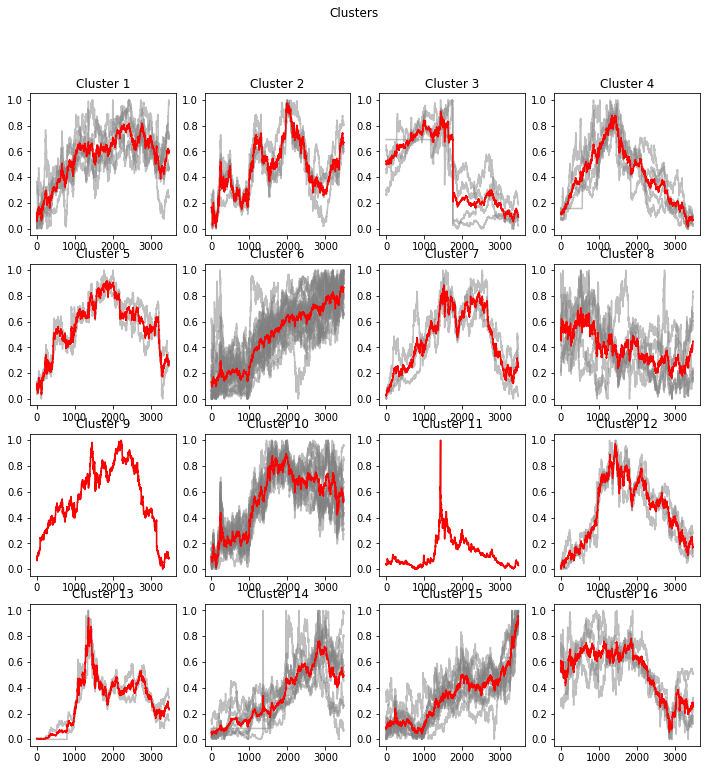

In [ ]:
win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

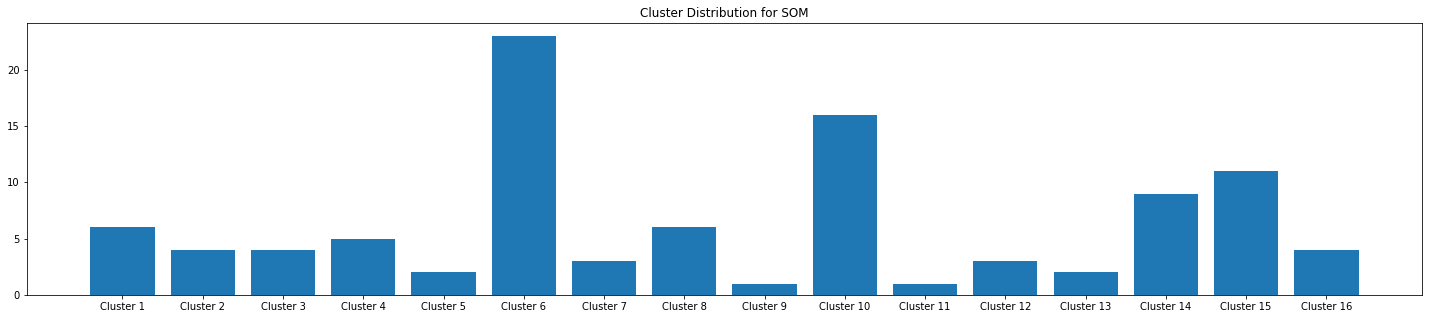

In [ ]:
# Cluster distribution
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

clusters = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [ ]:
clusters[clusters["Cluster"] == "Cluster 6"]